In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import phate
import math
import random
import gc
import scprep
from datetime import datetime, time
from matplotlib.animation import ImageMagickWriter
import matplotlib.animation as animation
import zipfile
from urllib.request import urlopen
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import kde
from scipy.stats import binned_statistic
from scipy.stats import f_oneway
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['pdf.fonttype'] = 42
print(sns.__version__)
from anndata import AnnData
import scanpy as sc
from delve import *
import anndata as ad
from sklearn.preprocessing import MinMaxScaler
from kh import sketch
from sklearn.cluster import KMeans
import umap
print(sc.__version__)
today = datetime.now().strftime("%m%d%Y-%H%M")

0.11.2
1.9.1


In [2]:
#Read back in the subsampled adata file
adata_save_path = r'Z:\Garrett\4i_data\050824_HuSynFibro_SenInduction\cell_data\standard_adata_sub_no_IR.h5ad'
adata_sub = anndata.read_h5ad(adata_save_path)

In [3]:
def laplacian_score_fs(adata = None,
                    k: int  = None,
                    n_jobs: int  = -1):

    X, feature_names, obs_names = parse_input(adata)
    W = construct_affinity(X = X, k = k, n_jobs = n_jobs)
    scores = laplacian_score(X = X, W = W)
    predicted_features = pd.DataFrame(scores, index = feature_names, columns = ['laplacian_score'])
    predicted_features = predicted_features.sort_values(by = 'laplacian_score', ascending = True)

    return predicted_features 

In [4]:
#l_score_fullest = laplacian_score_fs(adata_fullest_sub, k = 200)
l_score_standard = laplacian_score_fs(adata_sub, k = 100)
#l_score_normalized = laplacian_score_fs(normalized_trimmed_noPSTAT5_adata_sub, k = 200)

In [5]:
len(l_score_standard)

48

In [6]:
l_score_standard.index[:48]

Index(['total_IL6_nuc', 'R4_IL8_nuc_mean', 'total_pp65_nuc',
       'R4_PARP1_nuc_mean', 'total_PDPN_nuc', 'area', 'total_IL8_nuc',
       'R1_IL6_nuc_mean', 'R1_pp65_nuc_mean', 'R0_p21_nuc_mean',
       'R1_Jak2_ring_mean', 'R4_IL8_ring_mean', 'total_Jak2_nuc',
       'R3_pRB_nuc_mean', 'total_PARP1_nuc', 'R3_RB_ring_mean',
       'R1_Jak2_nuc_mean', 'total_p38_nuc', 'R0_p38_ring_mean',
       'R5_PDPN_nuc_mean', 'R0_p16_nuc_mean', 'total_GATA4_nuc',
       'total_p21_nuc', 'total_p16_nuc', 'total_pH2AX_nuc', 'R3_RB_nuc_mean',
       'R2_p53_ring_mean', 'total_p53_nuc', 'R4_PARP1_ring_mean',
       'R5_pH2AX_ring_mean', 'R5_pH2AX_nuc_mean', 'R0_p16_ring_mean',
       'R0_p38_nuc_mean', 'R1_pp65_ring_mean', 'R2_GATA4_nuc_mean',
       'R0_p21_ring_mean', 'R3_pRB_ring_mean', 'R2_p53_nuc_mean',
       'R1_IL6_ring_mean', 'R5_PDPN_ring_mean', 'minor_axis_length',
       'R0_DNA_nuc_mean', 'major_axis_length', 'pRB_RB', 'R2_GATA4_ring_mean',
       'total_DNA', 'orientation', 'R0_DNA_ring_

In [19]:
adata_sub.var_names

Index(['area', 'orientation', 'major_axis_length', 'minor_axis_length',
       'R0_DNA_nuc_mean', 'R0_p38_nuc_mean', 'R0_p16_nuc_mean',
       'R0_p21_nuc_mean', 'R1_Jak2_nuc_mean', 'R1_pp65_nuc_mean',
       'R1_IL6_nuc_mean', 'R2_p53_nuc_mean', 'R2_GATA4_nuc_mean',
       'R3_RB_nuc_mean', 'R3_pRB_nuc_mean', 'R4_IL8_nuc_mean',
       'R4_PARP1_nuc_mean', 'R5_pH2AX_nuc_mean', 'R5_PDPN_nuc_mean',
       'R0_DNA_ring_mean', 'R0_p38_ring_mean', 'R0_p16_ring_mean',
       'R0_p21_ring_mean', 'R1_Jak2_ring_mean', 'R1_pp65_ring_mean',
       'R1_IL6_ring_mean', 'R2_p53_ring_mean', 'R2_GATA4_ring_mean',
       'R3_RB_ring_mean', 'R3_pRB_ring_mean', 'R4_IL8_ring_mean',
       'R4_PARP1_ring_mean', 'R5_pH2AX_ring_mean', 'R5_PDPN_ring_mean',
       'total_DNA', 'pRB_RB', 'total_p16_nuc', 'total_p21_nuc',
       'total_p53_nuc', 'total_IL6_nuc', 'total_pp65_nuc', 'total_Jak2_nuc',
       'total_IL8_nuc', 'total_p38_nuc', 'total_GATA4_nuc', 'total_PARP1_nuc',
       'total_pH2AX_nuc', 'total_PDPN

In [17]:
import numpy as np
import scanpy as sc

# Assuming adata_sub is your AnnData object and 'gene_of_interest' is the column in .var_names

# Get the expression values for the gene of interest
gene_of_interest = 'total_p16_nuc'  # Replace with the actual gene name

# Initialize a new column for the threshold labels
adata_sub.obs[f'{gene_of_interest}_threshold'] = 'donotuse'

# Calculate percentiles and assign labels within each treatment group
for treatment in ['control', 'etop']:
    # Filter the data for the current treatment group
    treatment_mask = adata_sub.obs['treatment'] == treatment
    treatment_values = adata_sub[treatment_mask, gene_of_interest].X.toarray().flatten()
    
    # Calculate the 5th percentile and the 50th percentile for the treatment group
    p5 = np.percentile(treatment_values, 95)  # Top 5% (95th percentile)
    p50 = np.percentile(treatment_values, 50)  # Bottom 50% (50th percentile)
    
    # Assign labels based on the percentiles
    labels = np.where(treatment_values >= p5, 'high', 
                      np.where(treatment_values <= p50, 'low', 'donotuse'))
    
    # Update the threshold labels in the original AnnData object
    adata_sub.obs.loc[treatment_mask, f'{gene_of_interest}_threshold'] = labels

# Save or further process the updated AnnData object
# adata_sub.write('updated_adata_sub.h5ad')


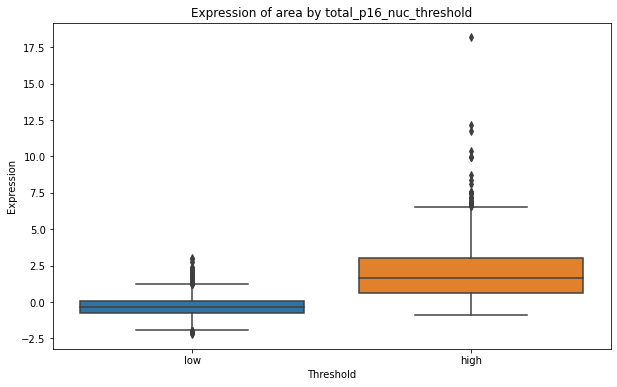

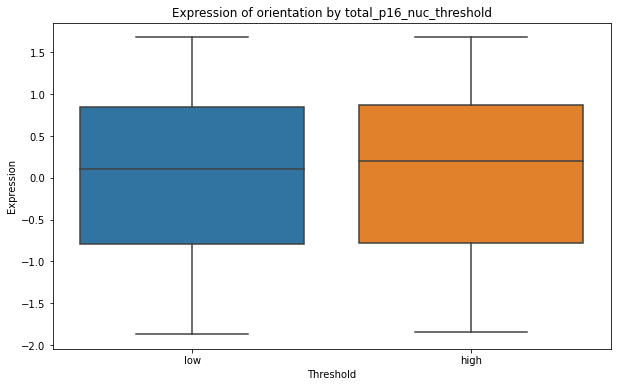

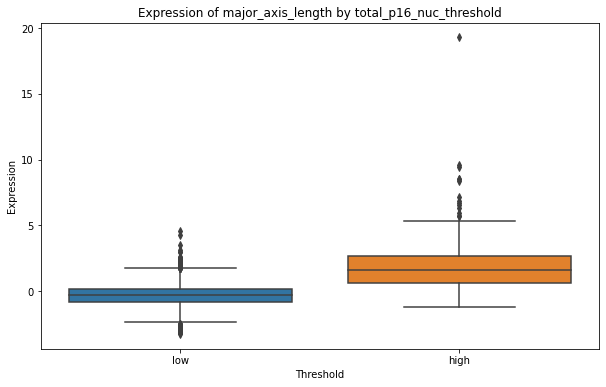

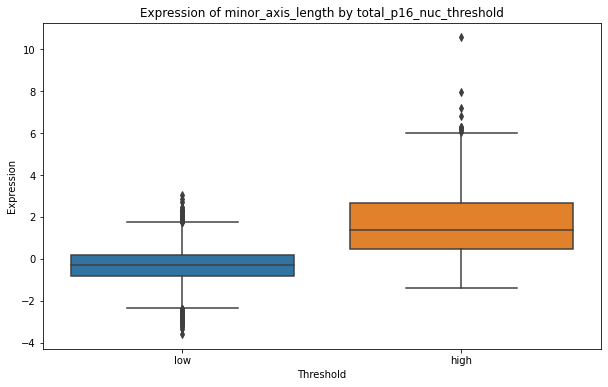

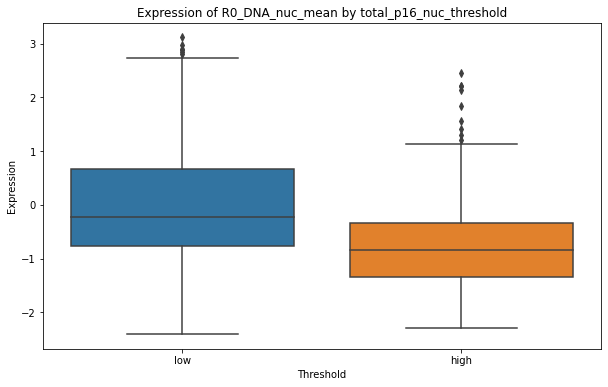

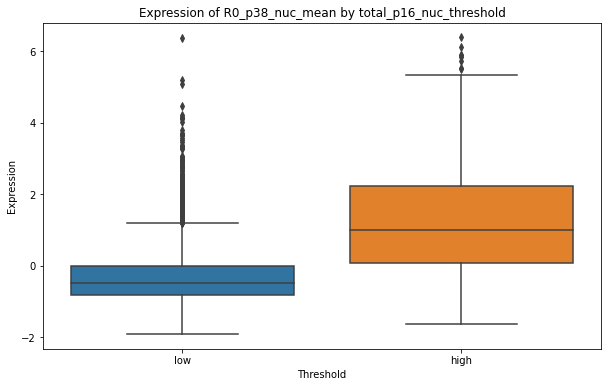

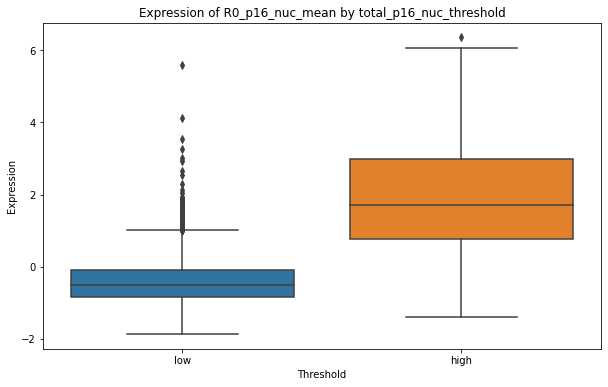

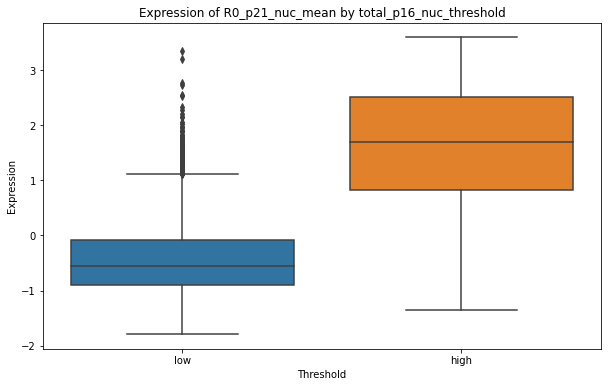

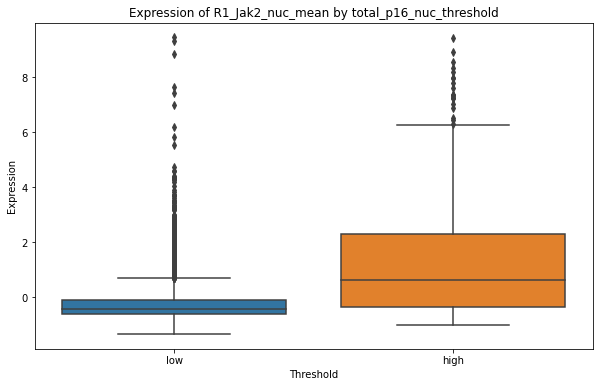

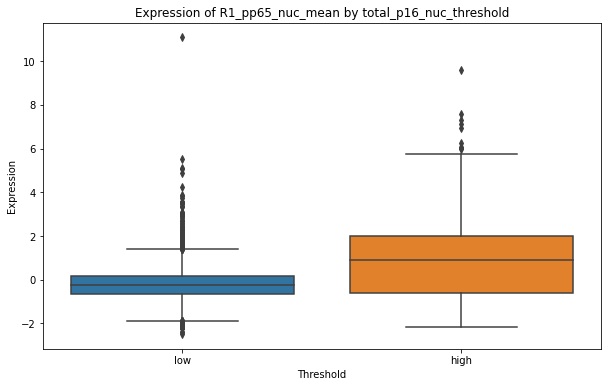

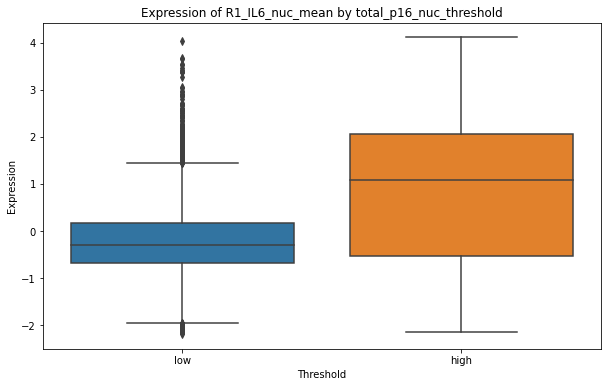

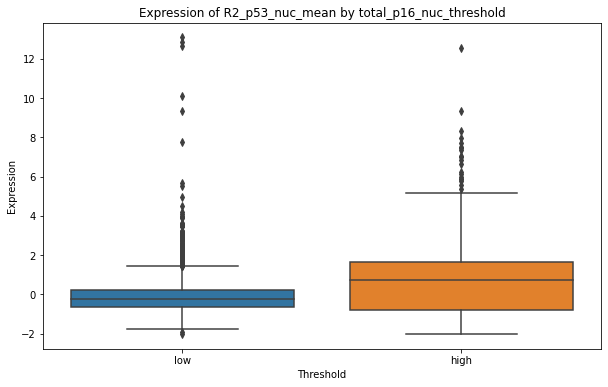

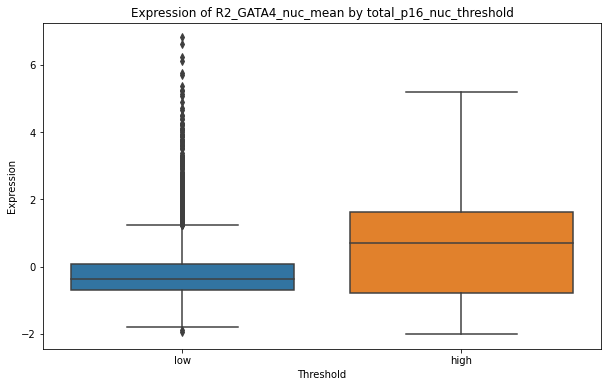

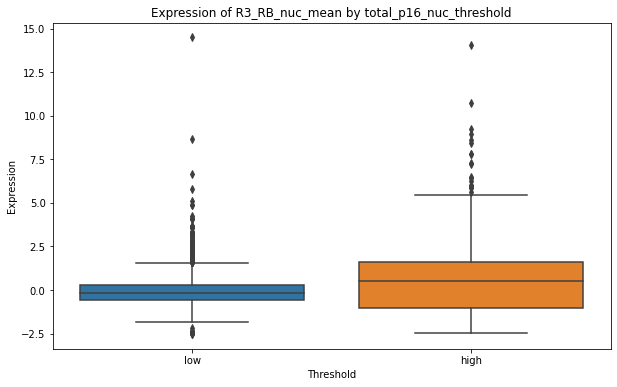

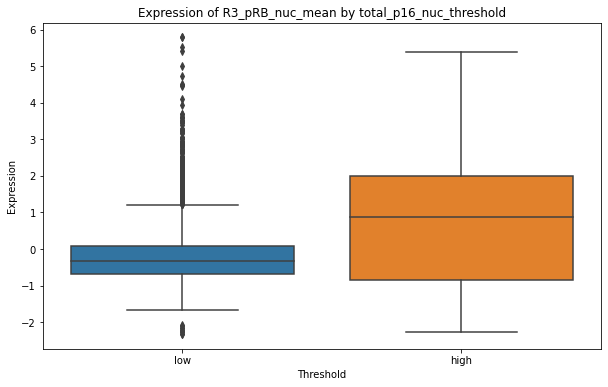

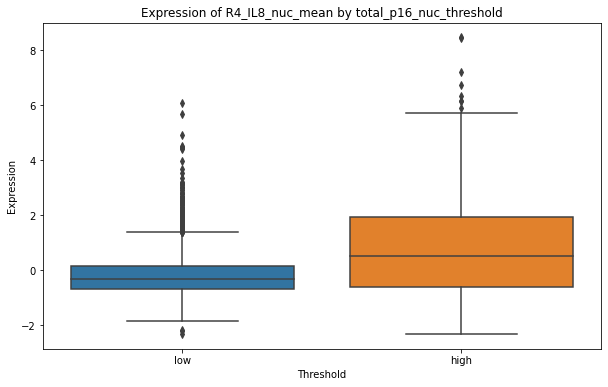

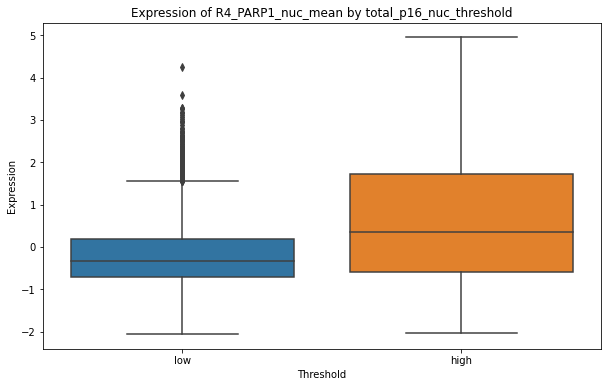

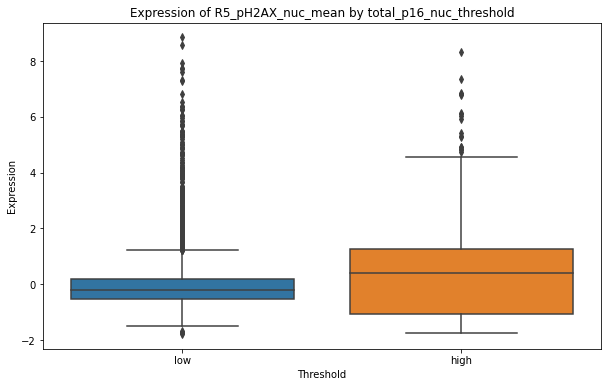

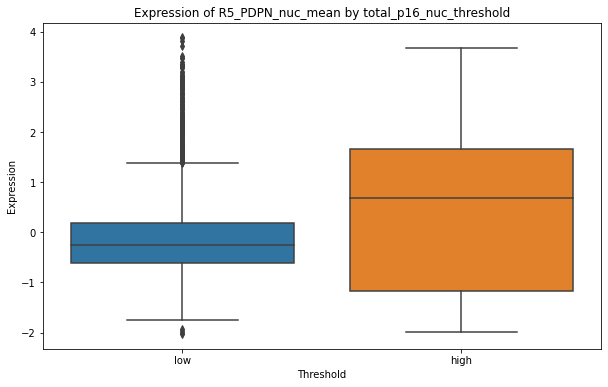

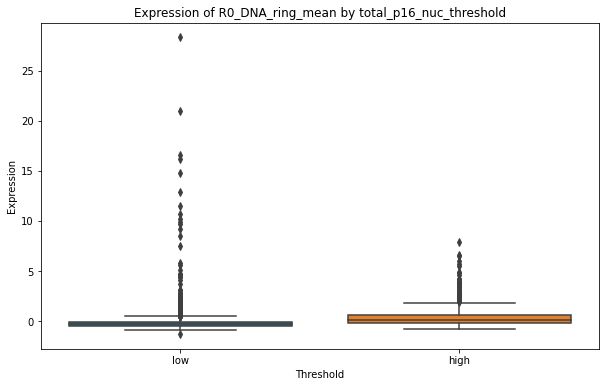

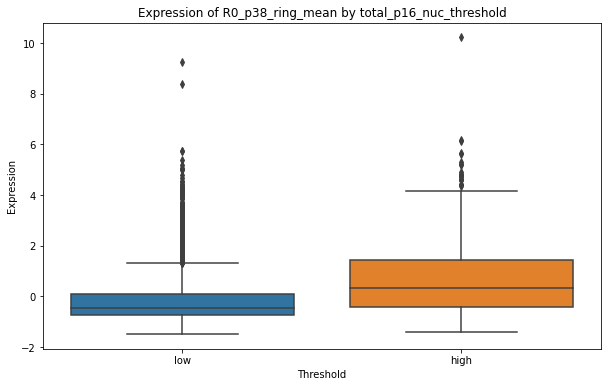

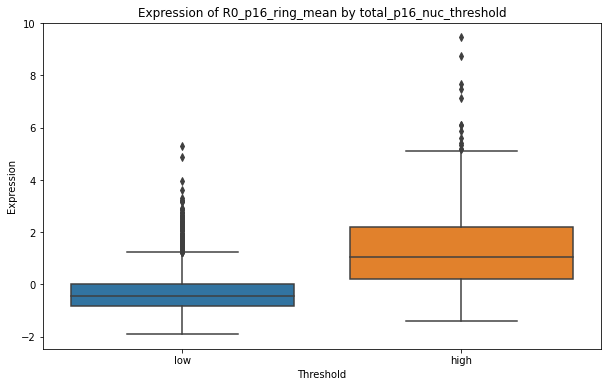

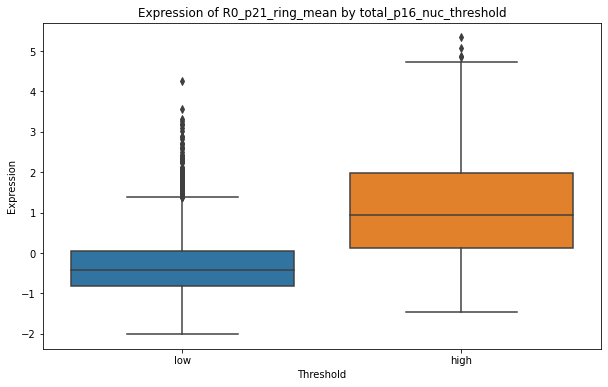

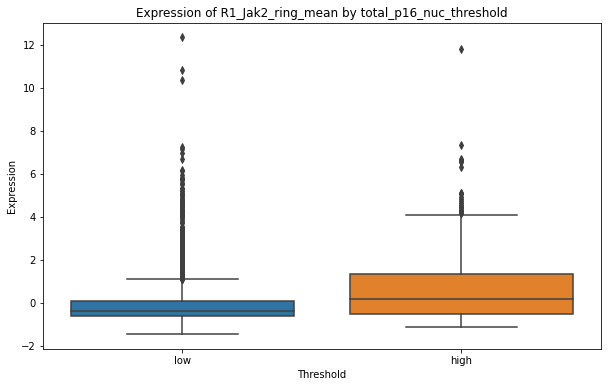

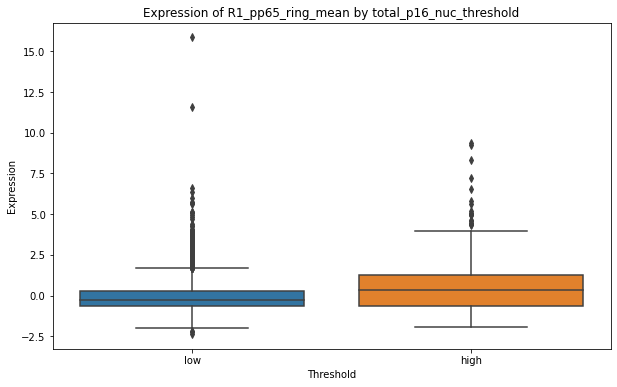

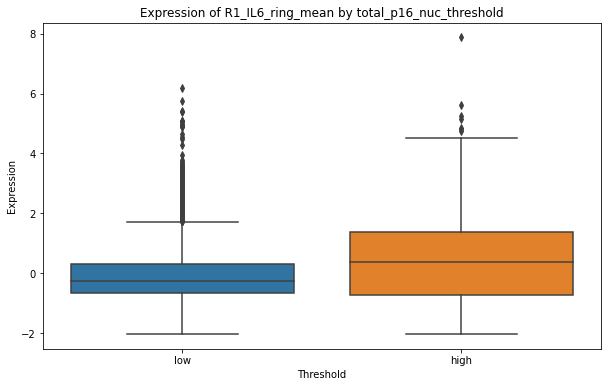

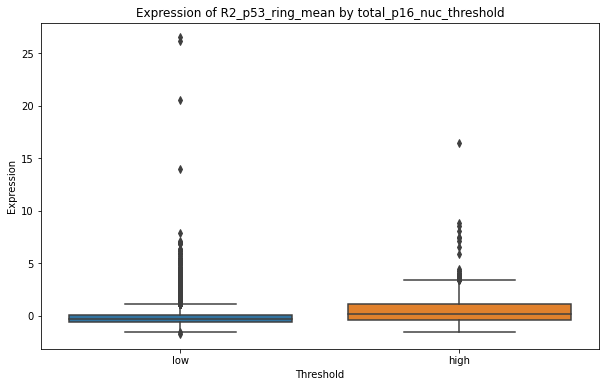

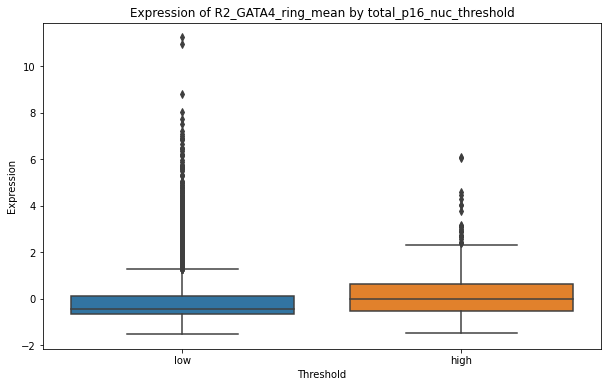

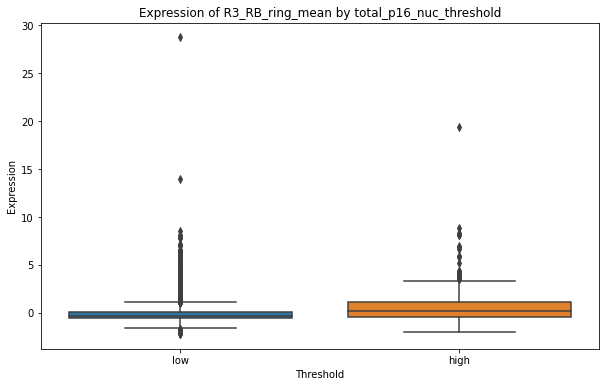

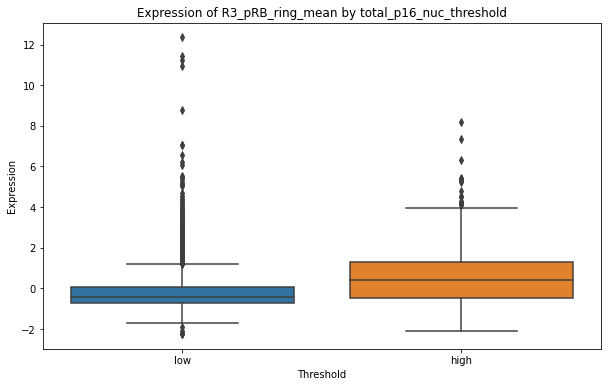

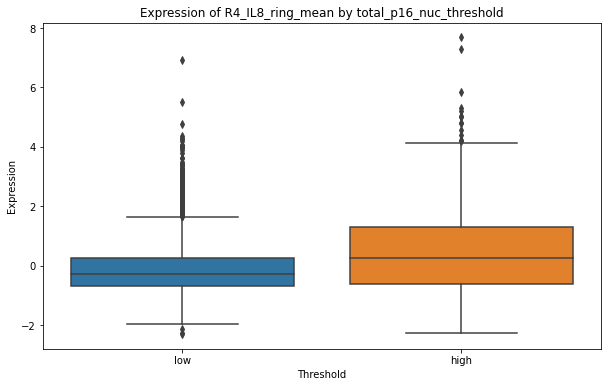

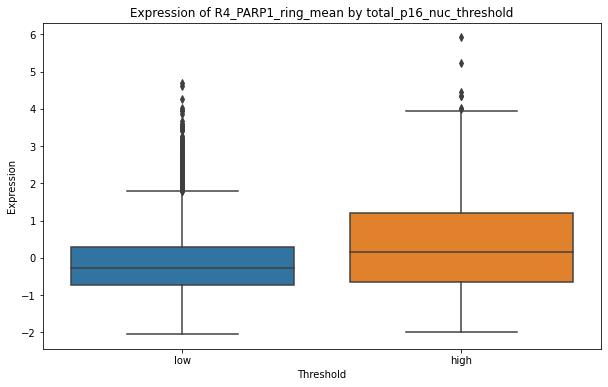

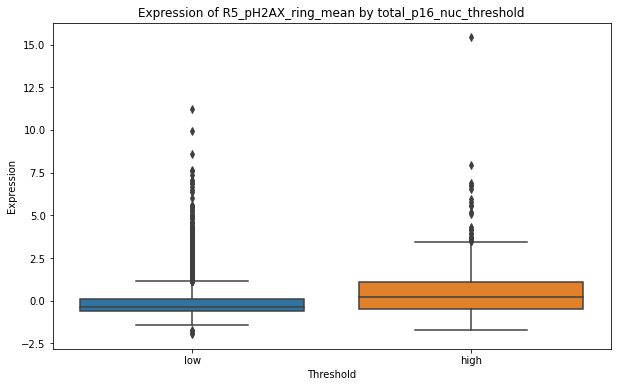

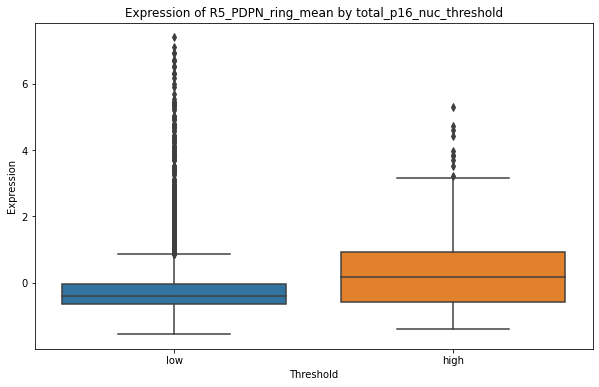

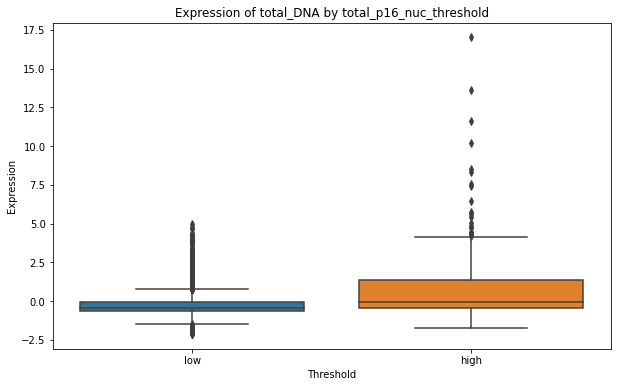

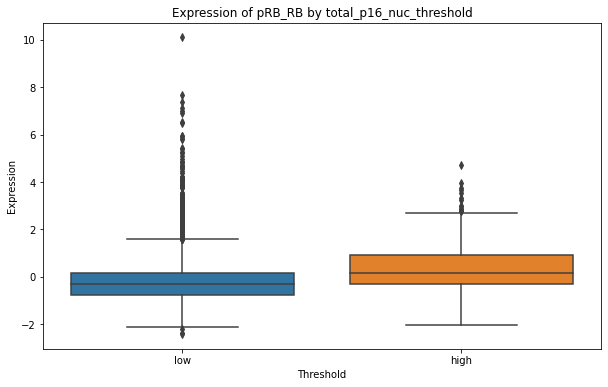

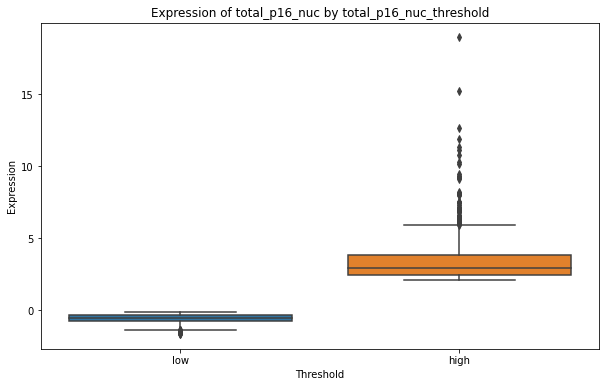

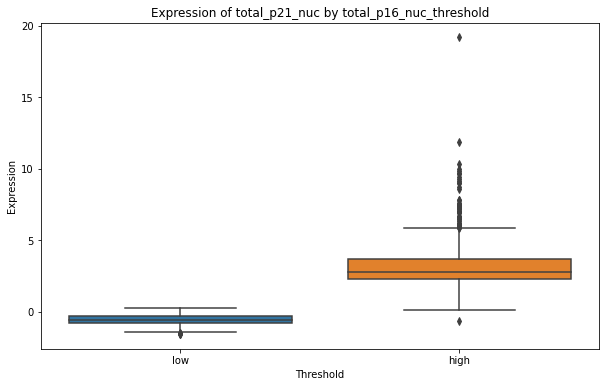

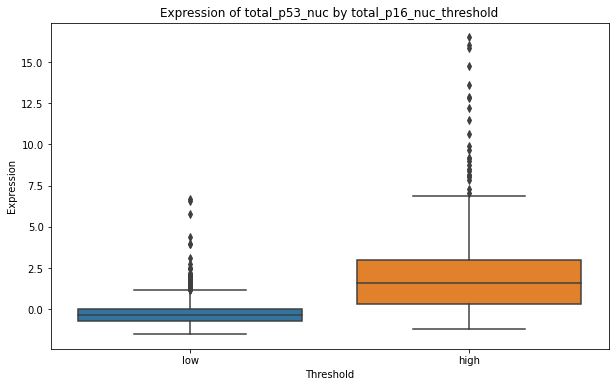

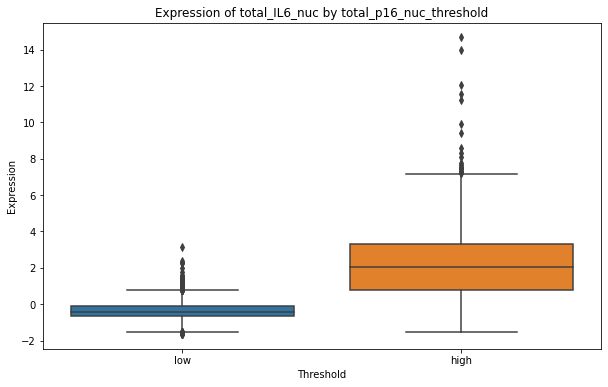

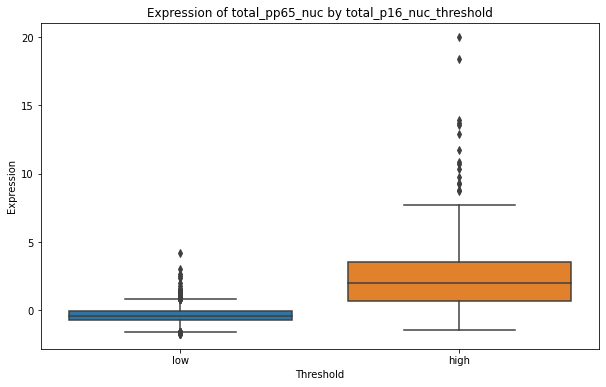

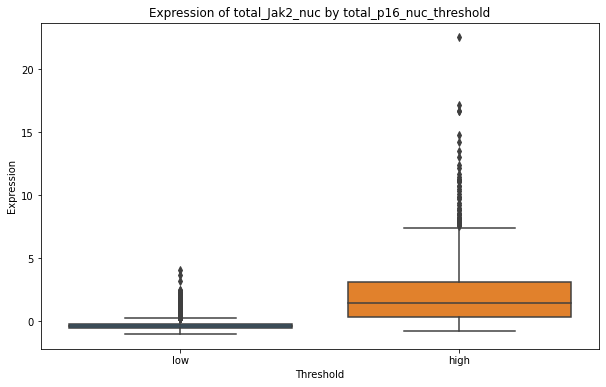

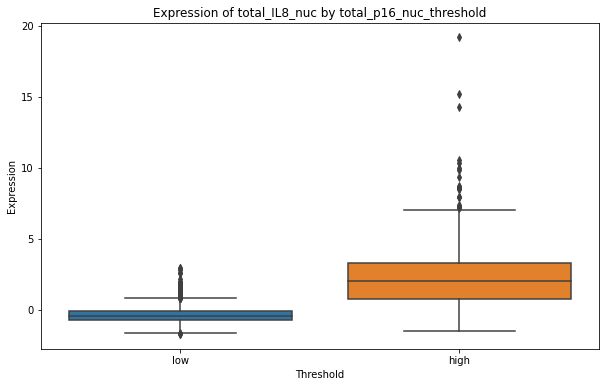

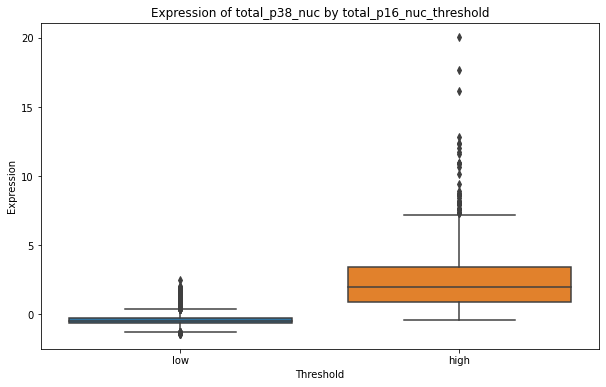

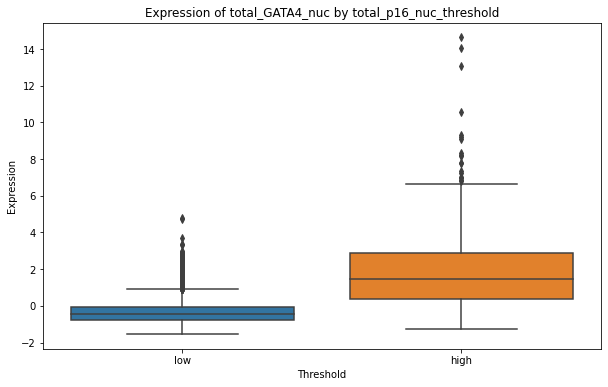

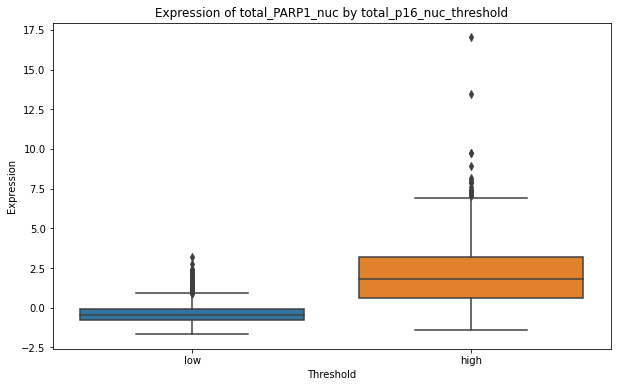

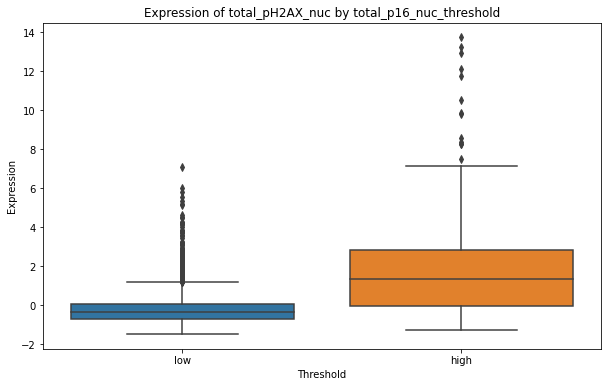

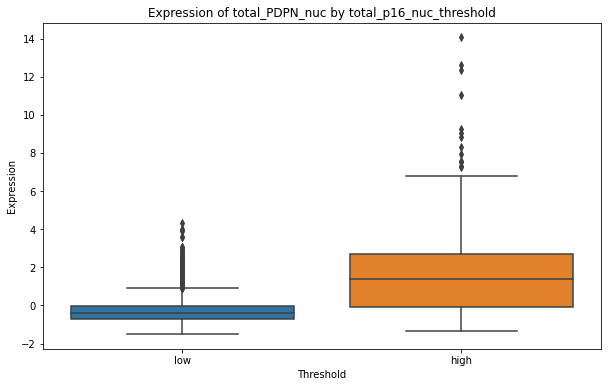

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot all features in var_names, comparing high and low
def plot_features_by_threshold(adata, threshold_column):
    # Filter out the 'donotuse' cells
    filtered_adata = adata[adata.obs[threshold_column] != 'donotuse']
    
    for feature in adata.var_names:
        # Get expression values for the feature
        expression_values = filtered_adata[:, feature].X.toarray().flatten()
        
        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'Expression': expression_values,
            'Threshold': filtered_adata.obs[threshold_column]
        })
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Threshold', y='Expression', data=plot_data)
        plt.title(f'Expression of {feature} by {threshold_column}')
        plt.xlabel('Threshold')
        plt.ylabel('Expression')
        plt.show()

# Call the function to plot features
plot_features_by_threshold(adata_sub, f'{gene_of_interest}_threshold')


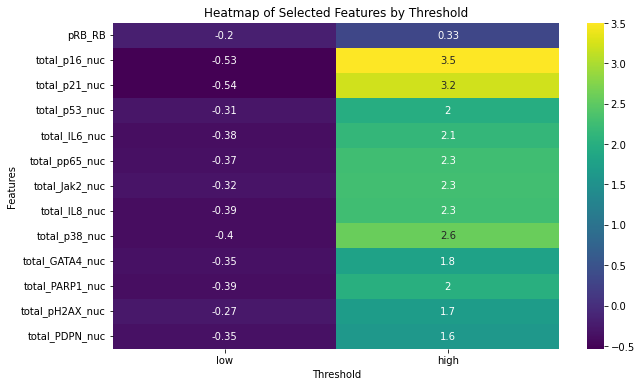

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmap_by_threshold_aggregated(adata, threshold_column, features):
    # Filter out the 'donotuse' cells
    filtered_adata = adata[adata.obs[threshold_column] != 'donotuse']
    
    # Initialize an empty DataFrame to store aggregated expression values
    aggregated_data = pd.DataFrame(index=['low', 'high'], columns=features)
    
    for feature in features:
        # Get expression values for the feature
        expression_values = filtered_adata[:, feature].X.toarray().flatten()
        
        # Get the threshold labels
        labels = filtered_adata.obs[threshold_column].values
        
        # Calculate the mean expression for 'low' and 'high' groups
        mean_low = np.mean(expression_values[labels == 'low'])
        mean_high = np.mean(expression_values[labels == 'high'])
        
        # Store the mean values in the DataFrame
        aggregated_data.loc['low', feature] = mean_low
        aggregated_data.loc['high', feature] = mean_high
    
    # Convert the data to float (to avoid issues with seaborn heatmap)
    aggregated_data = aggregated_data.astype(float)
    
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(aggregated_data.T, cmap='viridis', cbar=True, annot=True)
    plt.title('Heatmap of Selected Features by Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Features')
    plt.show()

# Specify the features to be plotted
selected_features = ['pRB_RB', 'total_p16_nuc', 'total_p21_nuc',
       'total_p53_nuc', 'total_IL6_nuc', 'total_pp65_nuc', 'total_Jak2_nuc',
       'total_IL8_nuc', 'total_p38_nuc', 'total_GATA4_nuc', 'total_PARP1_nuc',
       'total_pH2AX_nuc', 'total_PDPN_nuc']  # Replace with actual feature names

# Call the function to plot the heatmap
plot_heatmap_by_threshold_aggregated(adata_sub, f'{gene_of_interest}_threshold', selected_features)


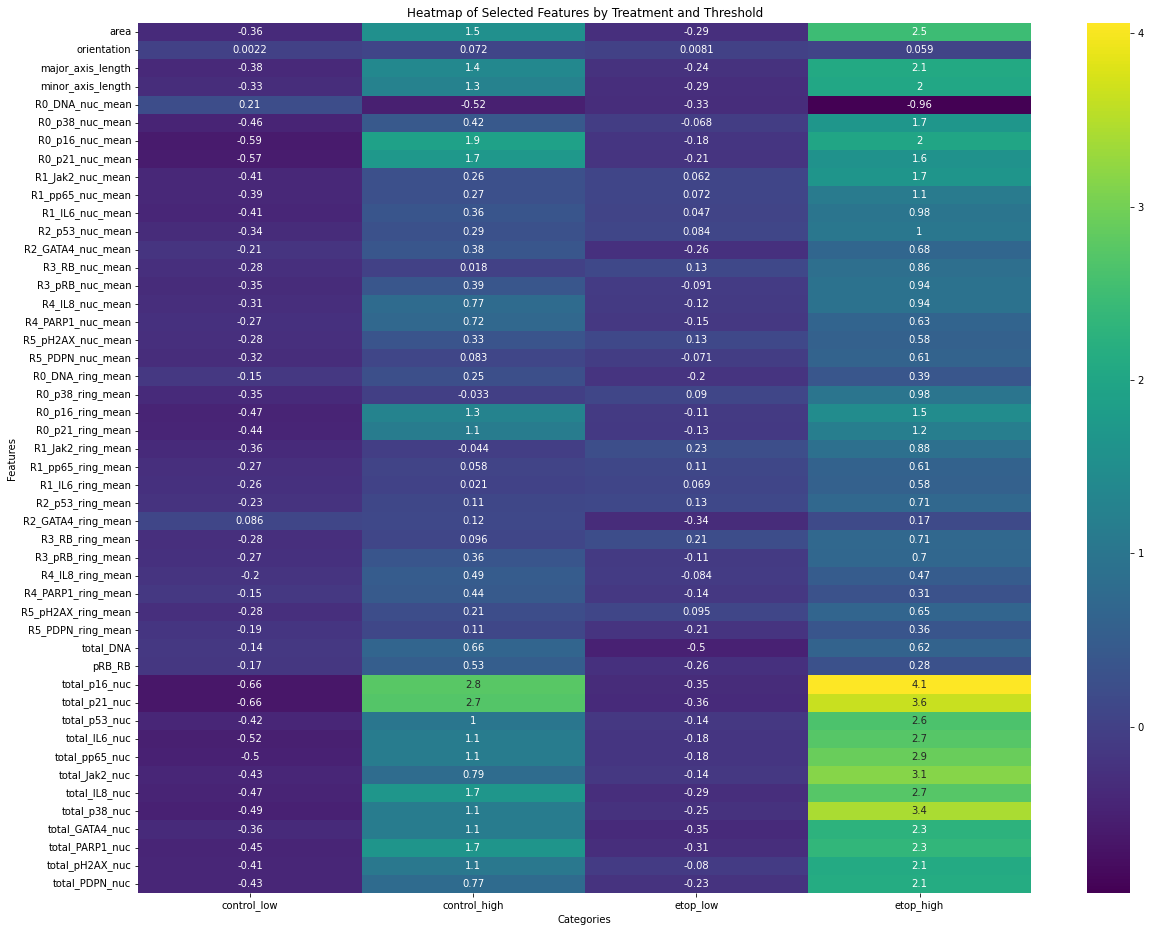

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_heatmap_by_threshold_and_treatment(adata, threshold_column, treatment_column, features):
    # Filter out the 'donotuse' cells
    filtered_adata = adata[adata.obs[threshold_column] != 'donotuse']
    
    # Initialize an empty DataFrame to store aggregated expression values
    categories = ['control_low', 'control_high', 'etop_low', 'etop_high']
    aggregated_data = pd.DataFrame(index=categories, columns=features)
    
    for feature in features:
        # Get expression values for the feature
        expression_values = filtered_adata[:, feature].X.toarray().flatten()
        
        # Get the threshold labels and treatment labels
        labels = filtered_adata.obs[threshold_column].values
        treatments = filtered_adata.obs[treatment_column].values
        
        # Calculate the mean expression for each category
        for treatment in ['control', 'etop']:
            for threshold in ['low', 'high']:
                category = f'{treatment}_{threshold}'
                mask = (treatments == treatment) & (labels == threshold)
                mean_value = np.mean(expression_values[mask])
                aggregated_data.loc[category, feature] = mean_value
    
    # Convert the data to float (to avoid issues with seaborn heatmap)
    aggregated_data = aggregated_data.astype(float)
    
    # Create the heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(aggregated_data.T, cmap='viridis', cbar=True, annot=True)
    plt.title('Heatmap of Selected Features by Treatment and Threshold')
    plt.xlabel('Categories')
    plt.ylabel('Features')
    plt.show()

# Specify the features to be plotted
selected_features = ['area', 'orientation', 'major_axis_length', 'minor_axis_length',
       'R0_DNA_nuc_mean', 'R0_p38_nuc_mean', 'R0_p16_nuc_mean',
       'R0_p21_nuc_mean', 'R1_Jak2_nuc_mean', 'R1_pp65_nuc_mean',
       'R1_IL6_nuc_mean', 'R2_p53_nuc_mean', 'R2_GATA4_nuc_mean',
       'R3_RB_nuc_mean', 'R3_pRB_nuc_mean', 'R4_IL8_nuc_mean',
       'R4_PARP1_nuc_mean', 'R5_pH2AX_nuc_mean', 'R5_PDPN_nuc_mean',
       'R0_DNA_ring_mean', 'R0_p38_ring_mean', 'R0_p16_ring_mean',
       'R0_p21_ring_mean', 'R1_Jak2_ring_mean', 'R1_pp65_ring_mean',
       'R1_IL6_ring_mean', 'R2_p53_ring_mean', 'R2_GATA4_ring_mean',
       'R3_RB_ring_mean', 'R3_pRB_ring_mean', 'R4_IL8_ring_mean',
       'R4_PARP1_ring_mean', 'R5_pH2AX_ring_mean', 'R5_PDPN_ring_mean',
       'total_DNA', 'pRB_RB', 'total_p16_nuc', 'total_p21_nuc',
       'total_p53_nuc', 'total_IL6_nuc', 'total_pp65_nuc', 'total_Jak2_nuc',
       'total_IL8_nuc', 'total_p38_nuc', 'total_GATA4_nuc', 'total_PARP1_nuc',
       'total_pH2AX_nuc', 'total_PDPN_nuc']  # Replace with actual feature names

# Call the function to plot the heatmap
plot_heatmap_by_threshold_and_treatment(adata_sub, f'{gene_of_interest}_threshold', 'treatment', selected_features)
